# Jia Zeng 8936740 - Lab 10
---

In [73]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

In [74]:
# path = "D:/Conestoga/CSCN8010/Lab10Data/train"

# folders = {f:len(os.listdir(os.path.join(path, f))) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))}

# # Print the 3 folders with the most files
# for folder, count in sorted(folders.items(), key=lambda item: item[1], reverse=True)[:3]:
#     print(folder, count)

In [75]:
path = pathlib.Path("./birds/")

In [76]:
train_dataset = image_dataset_from_directory(
    path / "train",
    image_size=(224, 224), # All images are 224 X 224 X 3 color images in jpg format
    batch_size=32,
    )
validation_dataset = image_dataset_from_directory(
    path / "valid",
    image_size=(224, 224), # All images are 224 X 224 X 3 color images in jpg format
    batch_size=32)
test_dataset = image_dataset_from_directory(
    path / "test",
    image_size=(224, 224), # All images are 224 X 224 X 3 color images in jpg format
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [77]:
data_gen = ImageDataGenerator(
    # rescale=1. / 255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = data_gen.flow_from_directory(
    path / "train",
    target_size= (224, 224),
    batch_size= 32,
    class_mode='categorical'
)

validation_gen = data_gen.flow_from_directory(
    path / "valid",
    target_size= (224, 224),
    batch_size= 32,
    class_mode='categorical'
)

test_gene = data_gen.flow_from_directory(
    path / "test", 
    target_size= (224, 224),
    batch_size= 32,
    class_mode='categorical' 
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


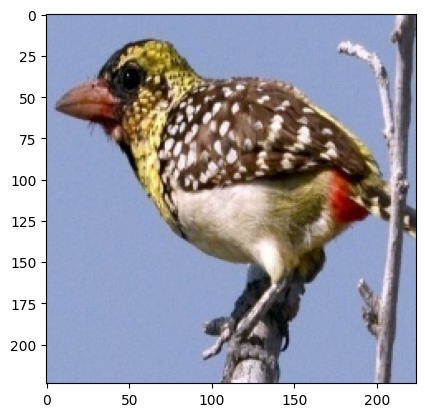

In [78]:
# get data
images, labels = next(train_gen)
image = images[0]
image = ((image - image.min()) * (255 / (image.max() - image.min()))).astype(np.uint8)
plt.imshow(image)

In [95]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 2s 2s/step


(744, 7, 7, 512)

In [102]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [103]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [106]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [107]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10


24/24 [==============================] - 17s 673ms/step - loss: -1104.9119 - accuracy: 0.3333 - val_loss: 94.4143 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 13s 522ms/step - loss: -1459.0978 - accuracy: 0.3333 - val_loss: 214.3786 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 13s 546ms/step - loss: -2056.1936 - accuracy: 0.3333 - val_loss: 309.5260 - val_accuracy: 0.3333
Epoch 4/10
24/24 [==============================] - 13s 549ms/step - loss: -2571.0645 - accuracy: 0.3333 - val_loss: 378.7578 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 13s 555ms/step - loss: -3045.8008 - accuracy: 0.3333 - val_loss: 422.9396 - val_accuracy: 0.3333
Epoch 6/10
24/24 [==============================] - 13s 547ms/step - loss: -3554.4839 - accuracy: 0.3333 - val_loss: 523.3583 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 13s 549ms/step - loss: -4197.5054 - accuracy: 0.3333 - val_loss: 5

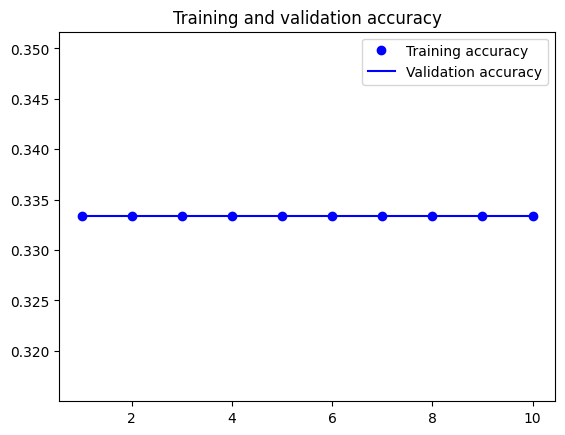

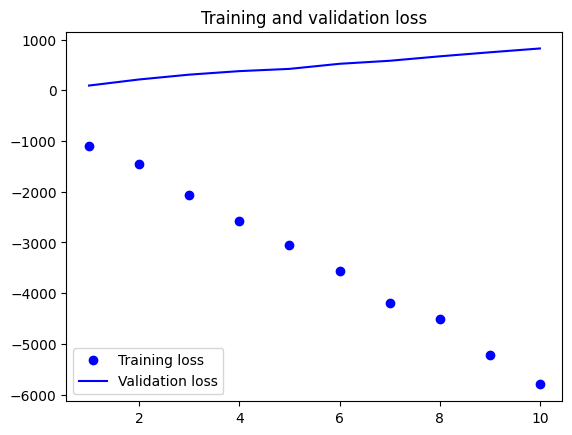

In [108]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [109]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 163ms/step - loss: 340.1784 - accuracy: 0.3333
Test accuracy: 0.333


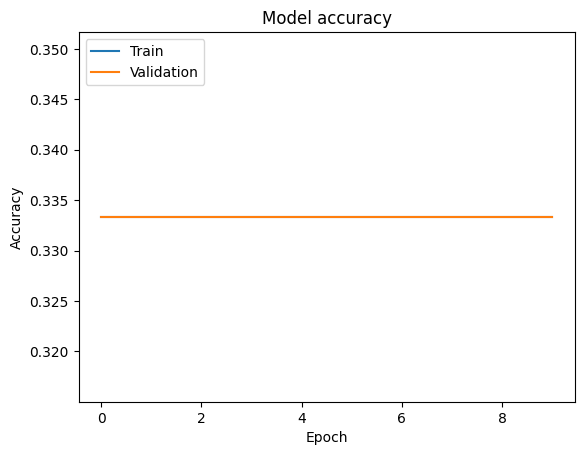

In [110]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---
# Magic code for Convert to HTML

jupyter nbconvert --to html ./students_submissions/8936740/Lab10.ipynb --output-dir ./docs/8936740 --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags="['noshow']"